# Classifying Objects in Images Using Deep Learning

We used basic neural networks in 8, Beating CAPTCHAs with Neural Networks. A recent flood of research in the area has led to a number of significant advances to that base design. Today, research in neural networks is creating some of the most advanced and accurate classification algorithms in many areas. These advances have come on the back of improvements in computational power, allowing us to train larger and more complex networks. However, the advances are much more than simply throwing more computational power at the problem. New algorithms and layer types have drastically improved performance, outside computational power.

Here, we will look at determining what object is represented in an image. The pixel values will be used as input, and the neural network will then automatically find useful combinations of pixels to form higher-level features. These will then be used for the actual classification. Overall we will examine the following:

- Classifying objects in images
- The different types of deep neural networks
- Libraries to build and train neural networks
- Using a GPU to improve the speed of the algorithms

## Object classification

Computer vision is becoming an important part of future technology. For example, we will have access to self-driving cars in the next five years (possibly much sooner, if some rumors are to be believed). In order to achieve this, the car's computer needs to be able to see around it: obstacles, other traffic, and weather conditions.

While we can easily detect whether there is an obstacle, for example using radar, it is also important we know what that object is. If it is an animal, it may move out of the way; if it is a building, it won't move at all and we need to go around it.

## Application scenario and goals

Here, we will build a system that will take an image as an input and give a prediction on what the object in it is. We will take on the role of a vision system for a car, looking around at any obstacles in the way or on the side of the road. Images are of the following form:

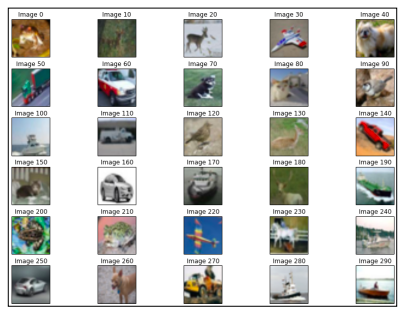

This dataset comes from a popular dataset called CIFAR-10. It contains 60,000 images that are 32 pixels wide and 32 pixels high, with each pixel having a red-green-blue (RGB) value. The dataset is already split into training and testing, although we will not use the testing dataset until after we complete our training.

The CIFAR-10 dataset is available for download at: https://www.cs.toronto.edu/~kriz/cifar.html. Download the python version, which has already been converted to NumPy arrays.

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline


BASE = 'data/cifar10/cifar-10-batches-py'
batch1_filename = BASE+'/data_batch_1'

In [2]:
import pickle
# Bigfix thanks to: http://stackoverflow.com/questions/11305790/pickle-incompatability-of-numpy-arrays-between-python-2-and-3
def unpickle(filename):
    with open(filename, 'rb') as fo:
        return pickle.load(fo, encoding='latin1')

In [3]:
batch1 = unpickle(batch1_filename)

In [4]:
image_index = 100
image = batch1['data'][image_index]

In [5]:
image = image.reshape((32,32, 3), order='F')
image = np.rot90(image, -1)

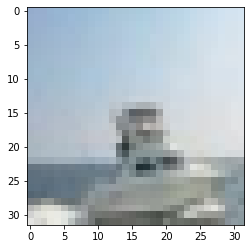

In [6]:
plt.imshow(image)


You can change the image index to show different images, getting a feel for the dataset's properties.

The aim of our project is to build a classification system that can take an image like this and predict what the object in it is

## Use cases

Computer vision is used in many scenarios.

Online map websites, such as Google Maps, use computer vision for a number of reasons. One reason is to automatically blur any faces that they find, in order to give some privacy to the people being photographed as part of their Street View feature.

Face detection is also used in many industries. Modern cameras automatically detect faces, as a means to improve the quality of photos taken (the user most often wants to focus on a visible face). Face detection can also be used for identification. For example, Facebook automatically recognizes people in photos, allowing for easy tagging of friends.

As we stated before, autonomous vehicles are highly dependent on computer vision to recognize their path and avoid obstacles. Computer vision is one of the key problems that is being addressed not only in research into autonomous vehicles, not just for consumer use, but also in mining and other industries.

Other industries are using computer vision too, including warehouses examining goods automatically for defects.

The space industry is also using computer vision, helping to automate the collection of data. This is critical for effective use of spacecraft, as sending a signal from Earth to a rover on Mars can take a long time and is not possible at certain times (for instance, when the two planets are not facing each other). As we start dealing with space-based vehicles more frequently, and from a greater distance, increasing the autonomy of these spacecrafts is absolutely necessary. 

## Deep neural networks

Beating CAPTCHAs with Neural Networks have some fantastic theoretical properties. For example, only a single hidden layer is needed to learn any mapping (although the size of the middle layer may need to be very, very big). Neural networks were a very active area of research in the 1970s and 1980s, and then these networks were no longer used, particularly compared to other classification algorithms such as support vector machines. One of the main issues was that the computational power needed to run many neural networks was more than other algorithms and more than what many people had access to.

Another issue was training the networks. While the back propagation algorithm has been known about for some time, it has issues with larger networks, requiring a very large amount of training before the weights settle.

## Intuition
The aspect that differentiates deep neural networks from the more basic neural network is size. A neural network is considered deep when it has two or more hidden layers. In practice, a deep neural network is often much larger, both in the number of nodes in each layer and also the number of layers. While some of the research of the mid2000s focused on very large numbers of layers, smarter algorithms are reducing the actual number of layers needed.

A neural network basically takes very basic features as inputs—in the case of computer vision, it is simple pixel values. Then, as that data is combined and pushed through the network, these basic features combine into more complex features. Sometimes, these features have little meaning to humans, but they represent the aspects of the sample that the computer looks for to make its classification.

## Implementation
A basic implementation of a neural network might start by creating a node class and collecting a set of these into a layer class. Each node is then connected to a node in the next layer using an instance of an Edge class. This type of implementation, a class-based one, is good to show how networks work, but is too inefficient for larger networks.

Neural networks are, at their core, simply mathematical expressions on matrices. The weights of the connections between one network and the next can be represented as a matrix of values, where the rows represent nodes in the first layer and the columns represent the nodes in the second layer (the transpose of this matrix is used sometimes too). The value is the weight of the edge between one layer and the next. A network can then be defined as a set of these weight matrices. In addition to the nodes, we add a bias term to each layer, which is basically a node that is always on and connected to each neuron in the next layer.

This insight allows us to use mathematical operations to build, train, and use neural networks, as opposed to creating a class-based implementation. These mathematical operations are great, as many great libraries of highly optimized code have been written that we can use to perform these computations as efficiently as we can.

We will start by implementing a basic neural network with Lasagne to introduce the concepts. We will then use nolearn to replicate our experiment in Chapter 8, Beating CAPTCHAs with Neural Networks, on predicting which letter is in an image. Finally, we will use a much more complex convolution neural network to perform image classification on the CIFAR dataset, which will also include running
this on GPUs rather than CPUs to improve the performance.

In [47]:
batches = []
for i in range(1, 6):
    batch_filename = os.path.join(BASE, "data_batch_{}".format(i))
    batches.append(unpickle(batch1_filename))


In [48]:
X = np.vstack([batch['data'] for batch in batches])
X = np.array(X) / X.max()
X = X.astype(np.float32)

In [49]:
X.shape

(50000, 3072)

In [59]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split


y = np.hstack(batch['labels'] for batch in batches).flatten()
y = OneHotEncoder().fit_transform(y.reshape(y.shape[0],1)).todense()
y = y.astype(np.float32)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) 
X_train = X_train.reshape(-1, 32, 32, 3)
X_test = X_test.reshape(-1, 32, 32, 3)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """


In [63]:
y_train.shape

(40000, 10)

In [69]:
X_train.shape

(40000, 32, 32, 3)

## Building a Simple Convolutional Neural Network with Keras
- Step 1: Importing Required Libraries
These lines import the necessary libraries from TensorFlow's Keras API. Sequential allows us to build a linear stack of layers, while Conv2D, MaxPooling2D, Flatten, and Dense represent the core components of our CNN.
- Step 2: Defining the Model Architecture
This section defines the architecture of our CNN. Let's break it down:
    1. We define the input shape as 32x32 color images (3 channels).
    2. The first Conv2D layer initializes the model with 32 filters, each of size 3x3. It uses ReLU activation.
    3. Two MaxPooling2D layers follow, reducing the spatial dimensions by half each time.
    4. Another pair of Conv2D and MaxPooling2D layers are added, increasing the number of filters to 64 and 128, respectively.
    5. The Flatten layer reshapes the output into a 1D vector.
    6. Two Dense layers are added: one with 512 units and ReLU activation, and another with the number of units equal to the number of classes, using softmax activation for multi-class classification.
- Step 3: Compiling the Model
Here, we configure the model for training:
    - We use the Adam optimizer.
    - The loss function is categorical crossentropy, suitable for multi-class classification.
    - Accuracy is chosen as a metric to monitor during training.
- Step 4: Training the Model
This final step trains our model on the training data:
    - We use X_train as input features and y_train as target labels.
    - The model is trained for 10 epochs.
    - A batch size of 32 is used.
    - 10% of the data is reserved for validation.

In [83]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Define input shape
input_shape = (32, 32, 3)

# Create Sequential model
model = Sequential([
    # Input layer
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    
    # Convolutional layers
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    
    # Flatten layer
    Flatten(),
    
    # Dense layers
    Dense(512, activation='relu'),
    Dense(y_train.shape[1], activation='softmax')
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.1)


Epoch 1/10
1125/1125 [==============================] - 69s 60ms/step - loss: 1.5821 - accuracy: 0.4281 - val_loss: 1.2883 - val_accuracy: 0.5422
Epoch 2/10
1125/1125 [==============================] - 62s 55ms/step - loss: 1.1086 - accuracy: 0.6036 - val_loss: 0.9477 - val_accuracy: 0.6678
Epoch 3/10
1125/1125 [==============================] - 59s 53ms/step - loss: 0.7065 - accuracy: 0.7532 - val_loss: 0.6320 - val_accuracy: 0.7803
Epoch 4/10
1125/1125 [==============================] - 59s 52ms/step - loss: 0.3586 - accuracy: 0.8829 - val_loss: 0.3223 - val_accuracy: 0.8953
Epoch 5/10
1125/1125 [==============================] - 63s 56ms/step - loss: 0.1676 - accuracy: 0.9469 - val_loss: 0.1424 - val_accuracy: 0.9553
Epoch 6/10
1125/1125 [==============================] - 53s 47ms/step - loss: 0.1025 - accuracy: 0.9667 - val_loss: 0.1372 - val_accuracy: 0.9610
Epoch 7/10
1125/1125 [==============================] - 62s 55ms/step - loss: 0.0800 - accuracy: 0.9741 - val_loss: 0.1570 -

In [86]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {accuracy}")

# Make predictions
y_pred = model.predict(X_test)

# Calculate F1 score
from sklearn.metrics import f1_score

y_pred_class = np.argmax(y_pred, axis=1)
y_test_class = np.argmax(y_test, axis=1)
f1 = f1_score(y_test_class, y_pred_class, average=None)
print(f"F1 scores: {f1} all")
f1 = f1_score(y_test_class, y_pred_class, average='weighted')
print(f"F1 scores: {f1} weighted")
f1 = f1_score(y_test_class, y_pred_class, average='micro')
print(f"F1 scores: {f1} micro")
f1 = f1_score(y_test_class, y_pred_class, average='macro')
print(f"F1 scores: {f1} macro")

313/313 [==============================] - 7s 21ms/step - loss: 0.1113 - accuracy: 0.9665
Test accuracy: 0.9664999842643738
F1 scores: [0.97191813 0.97892031 0.96631376 0.93035619 0.95976447 0.95155533
 0.9781393  0.97169811 0.97862454 0.97511427] all
F1 scores: 0.9663986631537069 weighted
F1 scores: 0.9665 micro
F1 scores: 0.9662404421493527 macro


## GPU optimization
Neural networks can grow quite large in size. This has some implications for memory use; however, efficient structures such as sparse matrices mean that we don't generally run into problems fitting a neural network in memory. 

The main issue when neural networks grow large is that they take a very long time to compute. In addition, some datasets and neural networks will need to run many epochs of training to get a good fit for the dataset. The neural network we will train in this chapter takes a minute per epoch on my reasonably powerful computer, and we expect to run dozens, potentially hundreds, of epochs. Some larger networks can take hours to train a single epoch. To get the best performance, you may be considering thousands of training cycles.

The math obviously doesn't give a nice result here.

One positive is that neural networks are, at their core, full of floating point operations. There are also a large number of operations that can be performed in parallel, as neural network training is composed of mainly matrix operations. These factors mean that computing on GPUs is an attractive option to speed up this training.

## When to use GPUs for computation
GPUs were originally designed to render graphics for display. These graphics are represented using matrices and mathematical equations on those matrices, which are then converted into the pixels that we see on our screen. This process involves lots of computation in parallel. While modern CPUs may have a number of cores (your computer may have 2, 4, or even 16—or more!), GPUs have
thousands of small cores designed specifically for graphics.

A CPU is therefore better for sequential tasks, as the cores tend to be individually faster and tasks such as accessing the computer's memory are more efficient. It is also, honestly, easier to just let the CPU do the heavy lifting. Almost every machine
learning library defaults to using the CPU, and there is extra work involved before you can use the GPU for computing. The benefits though, can be quite significant.

GPUs are therefore better suited for tasks in which there are lots of small operations on numbers that can be performed at the same time. Many machine learning tasks are like this, lending themselves to efficiency improvements through the use of a GPU.

Getting your code to run on a GPU can be a frustrating experience. It depends greatly on what type of GPU you have, how it is configured, your operating system, and whether you are prepared to make some low-level changes to your computer.

There are three main avenues to take:
- The first is to look at your computer, search for tools and drivers for your GPU and operating system, explore some of the many tutorials out there, and find one that fits your scenario. Whether this works depends on what your system is like. That said, this scenario is much easier than it was a few years ago, with better tools and drivers available to perform GPU-enabled computation.

- The second avenue is to choose a system, find good documentation on setting it up, and buy a system to match. This will work better, but can be fairly expensive—in most modern computers, the GPU is one of the most expensive parts. This is especially true if you want to get great performance out of the system—you'll need a really good GPU, which can be very expensive.

- The third avenue is to use a virtual machine, which is already configured for such a purpose. For example, Markus Beissinger has created such a system that runs on Amazon's Web Services. The system will cost you money to run, but the price is much less than that of a new computer. Depending on your location, the exact system you get and how much you use it, you are probably looking at less than $1 an hour, and often much, much less. If you use spot instances in Amazon's Web Services, you can run them for just a few cents per hour (although, you will need to develop your code to run on spot instances separately).

If you aren't able to afford the running costs of a virtual machine, I recommend that you look into the first avenue, with your current system. You may also be able to pick up a good secondhand GPU from family or a friend who constantly updates their computer (gamer friends are great for this!).

We will not implement GPU here and simply discuss this option if neccessary.